In [1]:
import matplotlib.pyplot as plt # creating visualizations
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning
from sklearn.preprocessing import MinMaxScaler


In [2]:
samples = 1000
min_max_scaler = MinMaxScaler()


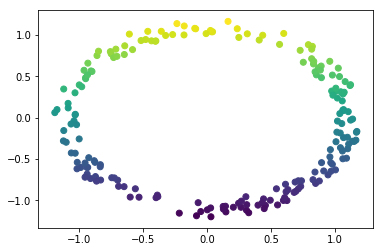

In [3]:
r = 1+torch.rand(samples*2,1)*0.2
theta = 2*3.1415926*torch.rand(samples*2,1)
x_data = torch.cos(theta)*r
y_data = torch.sin(theta)*r
x_data = x_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)


plt.scatter(x_data, y_data, c=y_data)

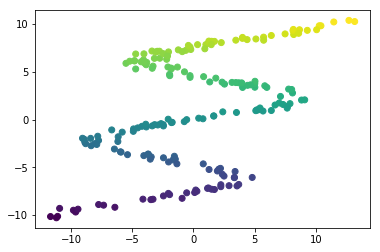

In [4]:
epsilon = np.random.normal(size=(samples*2))
y_data = np.random.uniform(-10.5, 10.5, samples*2)
x_data = 7*np.sin(0.75*y_data) + 0.5*y_data + epsilon

x_data = x_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)


plt.scatter(x_data, y_data, c=y_data)

In [3]:
x_data = np.random.uniform(-10, 10, (1, samples))
r_data = np.array([np.random.normal(scale=np.abs(i)) for i in x_data])
y_data = np.square(x_data)+r_data*2.0

x_data2 = np.random.uniform(-10, 10, (1, samples))
r_data2 = np.array([np.random.normal(scale=np.abs(i)) for i in x_data2])
y_data2 = -np.square(x_data2)+r_data2*2.0

x_data = np.concatenate((x_data,x_data2),axis=1).T
y_data = np.concatenate((y_data,y_data2),axis=1).T

min_max_scaler = MinMaxScaler()
y_data = min_max_scaler.fit_transform(y_data)

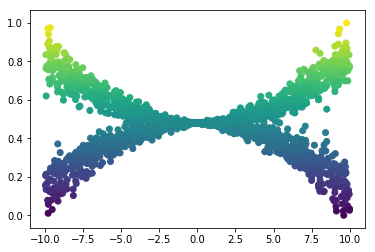

In [4]:
plt.scatter(x_data, y_data, c=y_data)

In [5]:
# oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
# def gaussian_distribution(y, mu, sigma):
#     # make |mu|=K copies of y, subtract mu, divide by sigma
#     result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
#     result = -0.5 * (result * result)
#     return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

# def mdn_loss_fn(pi, sigma, mu, y):
#     result = gaussian_distribution(y, mu, sigma) * pi
#     result = torch.sum(result, dim=1)
#     result = -torch.log(result + 1e-8)
#     return torch.mean(result)
logPi2 = np.log(np.pi * 2)
def mdn_loss_fn(pi, sigma, mu, y):
    y_expand = y.expand_as(mu)
    log_pi = torch.log(pi)
    log_pdf = -0.5*logPi2-torch.log(sigma)-0.5*((y_expand - mu) * torch.reciprocal(sigma)).pow(2)
    return -torch.logsumexp(log_pdf + log_pi, dim=1, keepdim=True).mean()

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  
    
    def sample(self, x):
        pi, sigma, mu = self.forward(x)
        pi_picked = torch.multinomial(pi, 1)
        res = []
        for i, r in enumerate(pi_picked):
            res.append(
                torch.normal(mu[i, r], sigma[i, r])
            )
        
        return torch.cat(res)
    
    def logits(self, x, y):
        pi, sigma, mu = self.forward(x)
        y_expand = y.expand_as(mu)
        log_pi = torch.log(pi)
        log_pdf = -0.5*logPi2-torch.log(sigma)-0.5*((y_expand - mu) * torch.reciprocal(sigma)).pow(2)
        return torch.logsumexp(log_pdf + log_pi, dim=1, keepdim=True)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

The mixture density network outputs the probability distribution $p(y | x)$ which 
we define as 
$$
    p(y | x) = \sum_k \pi_k(x) \phi(y | \mu_k(x), \sigma_k(x))
$$

In [10]:
model = MDN(n_hidden=40, n_gaussians=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
x = torch.FloatTensor(x_data)
y = torch.FloatTensor(y_data)

# versus this?
# x = Variable(x)
# y = Variable(y, requires_grad=False)

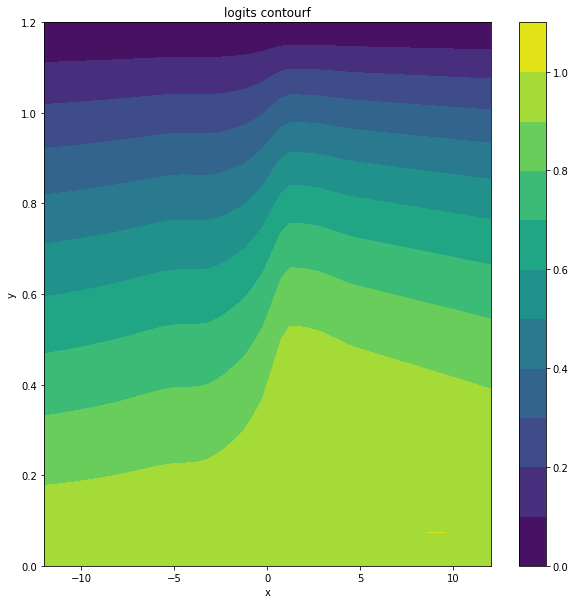

In [12]:
def plot_logits_contour(n=50):
    xs, ys = np.meshgrid(np.linspace(-12,12,n),np.linspace(-0,1.2,n))
    xs = torch.FloatTensor(xs.ravel()).view(-1,1)
    ys = torch.FloatTensor(ys.ravel()).view(-1,1)
    logits = model.logits(xs,ys)
    xs, ys, logits = (np.reshape(v.data.numpy(),[n,n]) for v in (xs, ys, logits))
    fig = plt.figure(figsize=[10,10])
    logits = min_max_scaler.fit_transform(logits)
    plt.contourf(xs, ys, logits, levels=10)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
#     plt.xlim(-12,12)
#     plt.ylim(-0.1, 1.1)
    plt.title('logits contourf')
plot_logits_contour()


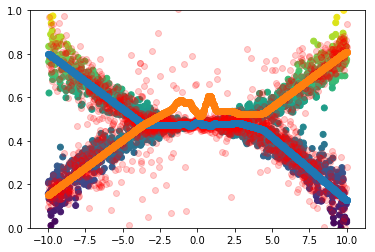

KeyboardInterrupt: 

In [13]:

def train_mdn():
    for epoch in range(10000):
#         pi_variable, sigma_variable, mu_variable = model(x)
#         loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y)
        loss = -model.logits(x, y).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(epoch, loss.item())
        if epoch % 5 == 0:
            clear_output(wait=True)
#             plot_logits_contour()
            pi_variable, sigma_variable, mu_variable = model(x)
            samples = model.sample(x).unsqueeze(1)
            mu_data = mu_variable.data.numpy()
            k = mu_data.shape[1]
            plt.scatter(x_data, y_data, c=y_data)
            plt.scatter(x_data, samples.data.numpy(), c='r', alpha=0.2)
            for i in range(k):
                plt.scatter(x_data, mu_data[:,i])
#             plt.xlim(-2,2)
            plt.ylim(0,1)
            
            plt.pause(0.01)
            

train_mdn()

In [ ]:
pi, sigma, mu = model(torch.FloatTensor([[0.5]]))

In [22]:
pdist = torch.distributions.Normal(mu, sigma)
y = torch.linspace(-2.,2)

ylike = pdist.log_prob(y.unsqueeze(1))
ydist = pi.mm(ylike.exp().t())

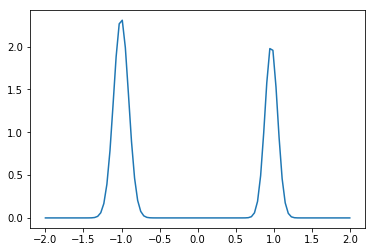

In [23]:
plt.plot(y.data.numpy(), ydist.data.numpy().squeeze())

In [57]:
pi_variable, sigma_variable, mu_variable = model(x)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

In [58]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

In [59]:
indices = (np.arange(samples*2), k)
rn = np.random.randn(samples*2)
sampled = rn * sigma_data[indices] + mu_data[indices]

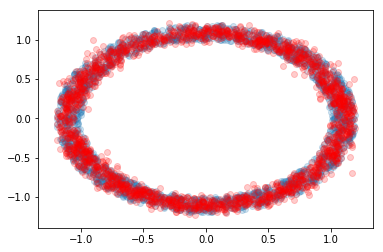

In [60]:
plt.figure()
plt.scatter(x_data, y_data, alpha=0.2)
# plt.scatter(x.data.numpy(), mu_variable.data.numpy()[:,0], alpha=0.2, color='red')
# plt.scatter(x.data.numpy(), mu_data[:,1], alpha=0.2, color='red')
plt.scatter(x.data.numpy(), sampled, alpha=0.2, color='red')

plt.show()

In [26]:
mu_variable.shape

torch.Size([400, 2])

In [12]:
mu_variable[:,[torch.multinomial(pi_variable, 1)]]

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
torch.normal()